In [1]:
import torch
import pandas as pd
from transformers import BertTokenizerFast, BertForSequenceClassification, BertForTokenClassification
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("../outputs/comparison", exist_ok=True)
print("Using device:", device)


📦 Using device: cuda


In [2]:
# Load tokenizer and both fine-tuned models (comment-level and token-level)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

model_a = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
model_a.load_state_dict(torch.load("../outputs/model/bert_toxic_classifier.pt", map_location=device))
model_a.to(device).eval()

model_b = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=2)
model_b.load_state_dict(torch.load("../outputs/model/bert_token_classifier.pt", map_location=device))
model_b.to(device).eval()


D:\New_Desktop\all stuff\ue\thesis-toxic\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [3]:
# Load Toxic Spans and clean empty rows
df = pd.read_csv("../data/toxic_spans.csv")
df["position"] = df["position"].apply(ast.literal_eval)
df["text_of_post"] = df["text_of_post"].astype(str).apply(lambda x: x.strip())
df = df[df["text_of_post"] != ""].reset_index(drop=True)

print(f"Evaluating on full dataset: {len(df)} samples")


📊 Evaluating on full dataset: 11006 samples


In [4]:
# Model A: comment-level classification on Toxic Spans
# Create binary label per comment: toxic if any gold span exists
labels = []
predictions = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text_of_post"]
    label = int(len(row["position"]) > 0)

    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model_a(**enc)
        pred = torch.argmax(outputs.logits, dim=1).item()

    labels.append(label)
    predictions.append(pred)

# Save per-sample predictions for Model A
df_model_a = pd.DataFrame({
    "index": df.index,
    "text": df["text_of_post"],
    "true_label": labels,
    "predicted_label": predictions,
    "model": "BERT-sequence"
})
df_model_a.to_csv("../outputs/comparison/model_a_classification.csv", index=False)
print("Saved: model_a_classification.csv")

# Print standard classification report
print("Model A — Comment-level Classification")
print(classification_report(labels, predictions, target_names=["non-toxic", "toxic"]))


  0%|          | 0/11006 [00:00<?, ?it/s]

✅ Saved: model_a_classification.csv
📊 Model A — Comment-level Classification
              precision    recall  f1-score   support

   non-toxic       0.75      0.24      0.36      5364
       toxic       0.56      0.92      0.70      5642

    accuracy                           0.59     11006
   macro avg       0.65      0.58      0.53     11006
weighted avg       0.65      0.59      0.53     11006



In [5]:
# Model B: token-level span detection scored at character level
threshold = 0.5
span_metrics = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text_of_post"]
    true_spans = set(row["position"]) # gold characters

    # Get token offsets to project token predictions back to character indices
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128, return_offsets_mapping=True)
    offset_mapping = enc.pop("offset_mapping")[0]
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = model_b(**enc)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).squeeze().cpu().tolist()

    # Collect predicted character indices from tokens labeled as toxic
    predicted_spans = set()
    for j, (start, end) in enumerate(offset_mapping):
        if j < len(preds) and preds[j] == 1 and start != end:
            predicted_spans.update(range(start, end))

    # Character-level precision/recall/F1 for this sample
    tp = len(predicted_spans & true_spans)
    fp = len(predicted_spans - true_spans)
    fn = len(true_spans - predicted_spans)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    span_metrics.append((precision, recall, f1))

# Save per-sample span metrics for Model B
span_df = pd.DataFrame(span_metrics, columns=["precision", "recall", "f1"])
span_df["index"] = df.index
span_df["text"] = df["text_of_post"]
span_df["model"] = "BERT-token"
span_df.to_csv("../outputs/comparison/model_b_span_metrics.csv", index=False)
print("Saved: model_b_span_metrics.csv")

# Save average stats separately
summary_stats = span_df[["precision", "recall", "f1"]].describe()
summary_stats.to_csv("../outputs/comparison/model_b_stats.csv")
print("Saved: model_b_stats.csv")

print("Model B — Token-Level Span Detection (Average)")
print(summary_stats)


  0%|          | 0/11006 [00:00<?, ?it/s]

✅ Saved: model_b_span_metrics.csv
✅ Saved: model_b_stats.csv
📊 Model B — Token-Level Span Detection (Average)
          precision        recall            f1
count  11006.000000  11006.000000  11006.000000
mean       0.429790      0.420764      0.418691
std        0.487568      0.482546      0.477664
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        1.000000      1.000000      0.999999
max        1.000000      1.000000      0.999999


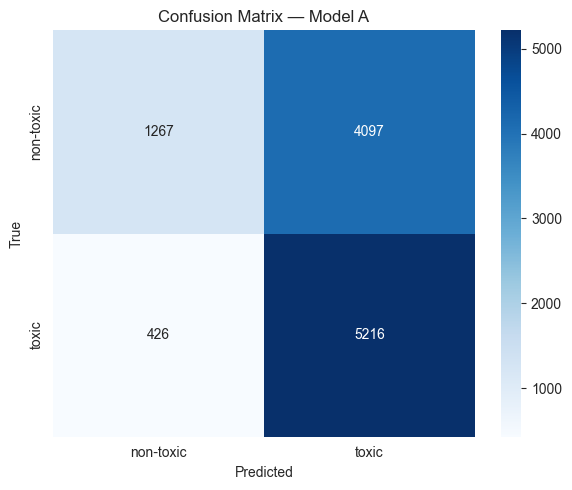

✅ Saved: confusion_matrix_model_a.png


In [6]:
# Confusion matrix for Model A (comment-level)
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-toxic", "toxic"], yticklabels=["non-toxic", "toxic"])
plt.title("Confusion Matrix — Model A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("../outputs/comparison/confusion_matrix_model_a.png")
plt.show()
print("Saved: confusion_matrix_model_a.png")


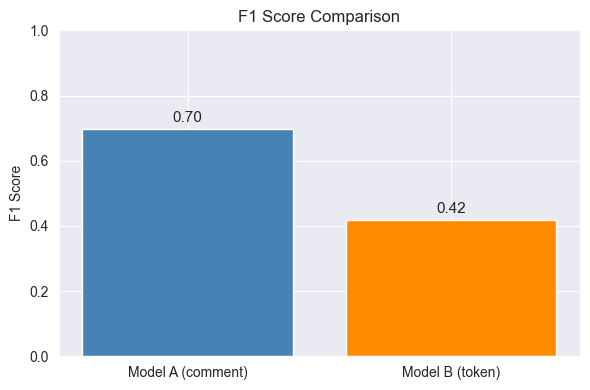

✅ Saved: f1_score_comparison.png


In [7]:
# F1 comparison plot (comment-level vs per-sample span F1 average)
f1_a = f1_score(labels, predictions)
f1_b = span_df["f1"].mean()

plt.figure(figsize=(6, 4))
bars = plt.bar(["Model A (comment)", "Model B (token)"], [f1_a, f1_b], color=["steelblue", "darkorange"])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha="center", fontsize=11)

plt.tight_layout()
plt.savefig("../outputs/comparison/f1_score_comparison.png")
plt.show()
print("Saved: f1_score_comparison.png")